In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from lifelines.utils import concordance_index
from skfda.representation.basis import BSplineBasis
from skfda.preprocessing.dim_reduction import FPCA
from skfda import FDataGrid
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import pandas as pd
from patsy import dmatrix
import os
from sklearn.model_selection import KFold


In [2]:
path = "/Users/polinaziboreva/Desktop/SPECIALE/"

csv_file = os.path.join(path, "data.csv")
data_analysis = pd.read_csv(csv_file)

In [3]:
data_analysis = data_analysis
act_mat_full = data_analysis.loc[:, "MIN1":"MIN1440"].to_numpy(dtype=float)

act_log_mat_full = np.log1p(act_mat_full)  

tlen = 1  
nt = 1440 // tlen  

inx_col_ls = [list(range(i * tlen, (i + 1) * tlen)) for i in range(nt)]
grouped = data_analysis.groupby("SEQN").indices

act_mat = np.vstack([np.nanmean(act_mat_full[idx, :], axis=0) for idx in grouped.values()])
act_log_mat = np.vstack([np.nanmean(act_log_mat_full[idx, :], axis=0) for idx in grouped.values()])

In [4]:
unique_data = data_analysis.loc[~data_analysis.duplicated("SEQN"), :].drop(columns=[col for col in data_analysis.columns if col.startswith("MIN")])
data_analysis = unique_data
data_analysis = data_analysis.drop(columns=["WEEKDAY", "good_day"] + [col for col in data_analysis.columns if col.startswith("Exclude")])

In [5]:
censor_mort = data_analysis['time_mort'] > 10
data_analysis.loc[censor_mort, 'event'] = 0
data_analysis.loc[censor_mort, 'time_mort'] = 10

In [6]:
def smooth_fpca(matrix: np.ndarray, n_basis: int = 35, n_components: int = 24) -> np.ndarray:
    n_samples, n_timepoints = matrix.shape
    grid_points = np.linspace(1, n_timepoints, n_timepoints)

    fd = FDataGrid(data_matrix=matrix, grid_points=grid_points)
    bspline_basis = BSplineBasis(domain_range=(1, n_timepoints), n_basis=n_basis)
    fd_basis = fd.to_basis(bspline_basis)

    fpca = FPCA(n_components=n_components, centering=True)
    fpca_scores = fpca.fit_transform(fd_basis)

    fpca_reconstruction = fpca.inverse_transform(fpca_scores).to_grid(grid_points=grid_points)

    return np.squeeze(fpca_reconstruction.data_matrix), fpca

def smooth_and_quantile_transform(matrix):
    result = np.zeros_like(matrix)
    for i in range(matrix.shape[1]):
        ecdf = ECDF(matrix[:, i])
        result[:, i] = ecdf(matrix[:, i])

    return result

In [7]:
act_log_mat_sm, fpcaTransformation = smooth_fpca(act_log_mat)
act_log_mat_sm_q = smooth_and_quantile_transform(act_log_mat_sm)

In [8]:
act_log_mat_ave = np.sum(act_log_mat_sm, axis=1) / act_log_mat_sm.shape[1]

In [9]:
np.random.seed(135)
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=135)
model = np.zeros(n_folds)

In [10]:
fixed_covariates = [
    'Alcohol', 'Overall_health', 'PIR', 'Employed', 'Age', 'BMI_cat', 'SmokeCigs',
    'Race', 'Education', 'CHD', 'Diabetes', 'CHF', 'Stroke', 'MobilityProblem', 'Cancer', 'time_mort', 'event'
    ]

data_dum = data_analysis[fixed_covariates]
data_dum = pd.get_dummies(data_dum, drop_first=True)

In [11]:
from sksurv.util import Surv

In [12]:
for fold_idx, (train_idx, test_idx) in enumerate(kf.split(data_dum['time_mort'])):
    print(f"Fold {fold_idx + 1}/{n_folds}")
    
    train_data = data_dum.iloc[train_idx]
    test_data = data_dum.iloc[test_idx]

    X_train = train_data.drop(columns=["time_mort", "event"])
    X_test = test_data.drop(columns=["time_mort", "event"])

    y_train = train_data["time_mort"].values
    w_train = train_data["event"].values

    y_test = test_data["time_mort"].values
    w_test = test_data["event"].values

    y_train_struct = Surv.from_arrays(event=w_train.astype(bool), time=y_train)
    y_test_struct = Surv.from_arrays(event=w_test.astype(bool), time=y_test)

    
    rsf = RandomSurvivalForest(
        n_estimators=50,
        min_samples_split=10,
        min_samples_leaf=15,
        max_features="sqrt",
        n_jobs=-1,
        random_state=135
    )

    rsf.fit(X_train, y_train_struct)

    test_risk_scores = rsf.predict(X_test)

    ci_test = concordance_index(
            event_times=w_test,
            predicted_scores=test_risk_scores,
            event_observed=y_test)

    print(f"Test Concordance Index: {ci_test:.3f}")

    model[fold_idx] = ci_test

Fold 1/10
Test Concordance Index: 0.773
Fold 2/10
Test Concordance Index: 0.822
Fold 3/10
Test Concordance Index: 0.797
Fold 4/10
Test Concordance Index: 0.867
Fold 5/10
Test Concordance Index: 0.832
Fold 6/10
Test Concordance Index: 0.824
Fold 7/10
Test Concordance Index: 0.786
Fold 8/10
Test Concordance Index: 0.816
Fold 9/10
Test Concordance Index: 0.833
Fold 10/10
Test Concordance Index: 0.761


In [13]:
np.mean(np.round(model,3))

np.float64(0.8111)

In [19]:
feature_names = X_train.columns.tolist()
print(feature_names)


['Age', 'Alcohol_Missing alcohol', 'Alcohol_Moderate Drinker', 'Alcohol_Non-Drinker', 'Overall_health_Fair', 'Overall_health_Good', 'Overall_health_Poor', 'Overall_health_Very good', 'PIR_[1.0, 2.5)', 'PIR_[2.5, inf)', 'Employed_Employed: part time', 'Employed_Unemployed: healthy', 'Employed_Unemployed: unhealthy', 'BMI_cat_Obese', 'BMI_cat_Overweight', 'BMI_cat_Underweight', 'SmokeCigs_Former', 'SmokeCigs_Never', 'Race_Mexican American', 'Race_Other', 'Race_Other Hispanic', 'Race_White', 'Education_High school', 'Education_Less than high school', 'Education_More than high school', 'Education_Refused', 'CHD_No', 'CHD_Yes', 'Diabetes_No', 'Diabetes_Yes', 'CHF_No', 'CHF_Yes', 'Stroke_No', 'Stroke_Yes', 'MobilityProblem_No Difficulty', 'Cancer_No', 'Cancer_Yes']


In [ ]:
importances = pd.DataFrame({'Feature': feature_names})


In [22]:
from sksurv.metrics import concordance_index_censored
import numpy as np
import pandas as pd

def c_index(model, X, y_struct):
    return concordance_index_censored(
        y_struct["event"], y_struct["time"], model.predict(X)
    )[0]

baseline_score = c_index(rsf, X_train, y_train_struct)
importances = []

for col in X_train.columns:
    X_permuted = X_train.copy()
    X_permuted[col] = np.random.permutation(X_permuted[col])
    score = c_index(rsf, X_permuted, y_train_struct)
    importances.append(baseline_score - score)

importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(importance_df)


                            Feature  Importance
0                               Age    0.105718
34    MobilityProblem_No Difficulty    0.022813
17                  SmokeCigs_Never    0.015715
2          Alcohol_Moderate Drinker    0.009021
11     Employed_Unemployed: healthy    0.007930
35                        Cancer_No    0.004759
9                    PIR_[2.5, inf)    0.004517
23  Education_Less than high school    0.004276
31                          CHF_Yes    0.003952
29                     Diabetes_Yes    0.003928
12   Employed_Unemployed: unhealthy    0.003819
16                 SmokeCigs_Former    0.003790
14               BMI_cat_Overweight    0.003652
8                    PIR_[1.0, 2.5)    0.003495
24  Education_More than high school    0.003145
5               Overall_health_Good    0.002948
28                      Diabetes_No    0.002907
3               Alcohol_Non-Drinker    0.002881
21                       Race_White    0.002635
4               Overall_health_Fair    0

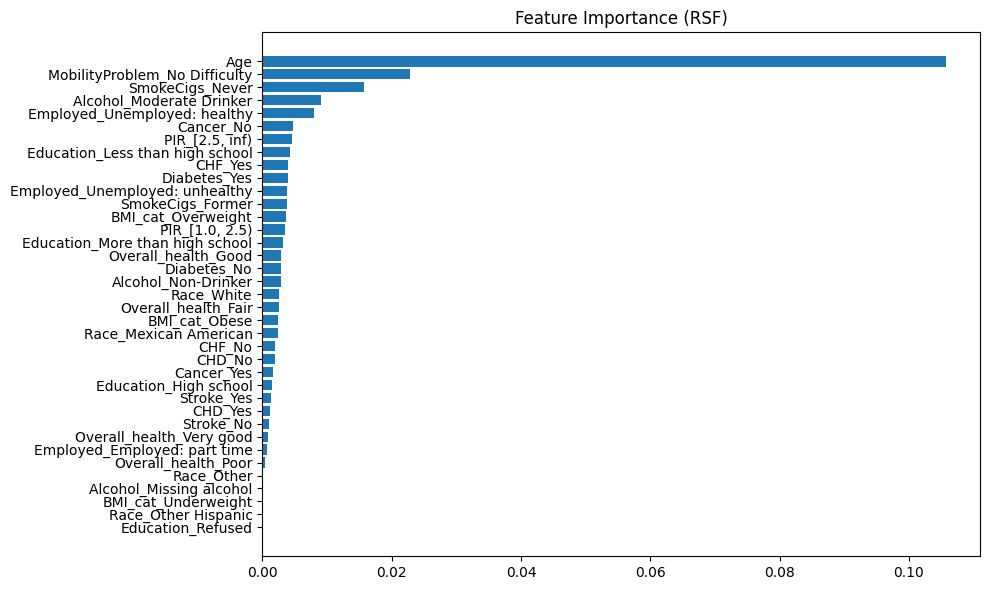

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance (RSF)")
plt.tight_layout()
plt.show()
